---
syncID: e046a83d83f2042d8b40dea1b20fd6779
title: "Band Stacking, RGB & False Color Images, and Interactive Widgets in Python - Tiled Data"
description: "Learn to efficintly work with tiled NEON AOP spectral data using functions."
dateCreated: 2017-06-19 
authors: Bridget Hass
contributors:
estimatedTime:
packagesLibraries: numpy, matplotlib, h5py, os, osr, copy
topics: hyperspectral-remote-sensing, HDF5, remote-sensing
languagesTool: python
dataProduct: NEON.DP3.30006, NEON.DP3.30008
code1: https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/Hyperspectral/indices/NEON_AOP_Hyperspectral_Functions_Tiles_py/NEON_AOP_Hyperspectral_Functions_Tiles_py.ipynb
tutorialSeries: intro-hsi-tiles-py-series
urlTitle: neon-hsi-aop-functions-tiles-python

---

In the tutorial, we learn how to efficiently read in hdf5 data using h5py, 
apply the no-data value and scale factor, and plot a single band of a 
reflectance data tile using functions built for NEON AOP data.  We will 
introduce functions `aop_h5refl2array`, plot different combinations of 
bands, and demonstrate how to create `IPython widgets` for more interactive 
data visualization. 

<div id="ds-ojectives" markdown="1">

### Objectives
After completing this tutorial, you will be able to:

* Upload a Python module
* Efficiently work with NEON hyperspectral data using functions, including: 
	+ Read in tiled NEON AOP reflectance hdf5 data and associated metadata
	+ Stack and plot 3-band combinations (eg. RGB, Color Infrared, False Color Images)
* Use IPython widgets to explore RGB band combinations interactively 
* Understand how to write and use functions and loops to automate repeated processes

### Install Python Packages

* **numpy**
* **pandas**
* **gdal** 
* **matplotlib** 
* **h5py**


### Download Data

{% include/dataSubsets/_data_DI18.html %}

[[nid:7489]]


</div>



We can combine any three bands from the NEON reflectance data to make an RGB 
image that will depict different information about the Earth's surface. 
A **natural color** image, made with bands from the red, green, and blue 
wavelengths looks close to what we would see with the naked eye. We can also 
choose band combinations from other wavelenghts, and map them to the red, blue, 
and green colors to highlight different features. A **false color** image is 
made with one or more bands from a non-visible portion of the electromagnetic 
spectrum that are mapped to red, green, and blue colors. These images can 
display other information about the landscape that is not easily seen with a 
natural color image. 

The NASA Goddard Media Studio video "Peeling Back Landsat's Layers of Data" 
gives a good quick overview of natural and false color band combinations. Note 
that Landsat collects information from 11 wavelength bands, while NEON AOP 
hyperspectral data collects information from 426 bands!

#### Peeling Back Landsat's Layers of Data Video

<iframe width="560" height="315" src="https://www.youtube.com/embed/YP0et8l_bvY" frameborder="0" allowfullscreen></iframe>


### Further Reading

* Check out the NASA Earth Observatory article 
<a href="https://earthobservatory.nasa.gov/Features/FalseColor/" target="_blank">How to Interpret a False-Color Satellite Image</a>. 
* Read the supporting article for the video above, 
<a href="https://svs.gsfc.nasa.gov//vis/a010000/a011400/a011491/index.html" target="_blank"> Landsat 8 Onion Skin</a>. 


## Load Function Module

Before we get started, let's set up our plot and warning preferences:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py, os, osr, copy
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

The first function we will use is `aop_h5refl2array`. This function is loaded into the cell below, we encourage you to look through the code to understand what it is doing -- most of these steps should look familiar to you from the first lesson. This function can be thought of as a wrapper to automate the steps required to read AOP hdf5 reflectance tiles into a Python format. This function also cleans the data: it sets any no data values within the reflectance tile to `nan` (not a number) and applies the reflectance scale factor so the final array that is returned represents unitless scaled reflectance, with values ranging between 0 and 1 (0-100%). 

In [2]:
def aop_h5refl2array(refl_filename):
    """aop_h5refl2array reads in a NEON AOP reflectance hdf5 file and returns 
           1. reflectance array (with the no data value and reflectance scale factor applied)
           2. dictionary of metadata including spatial information, and wavelengths of the bands
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata:
            bad_band_window1 (tuple)
            bad_band_window2 (tuple)
            bands: # of bands (float)
            data ignore value: value corresponding to no data (float)
            epsg: coordinate system code (float)
            map info: coordinate system, datum & ellipsoid, pixel dimensions, and origin coordinates (string)
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: wavelength values (float)
            wavelength unit: 'm' (string)
    --------
    NOTE: This function applies to the NEON hdf5 format implemented in 2016, and should be used for
    data acquired 2016 and after. Data in earlier NEON hdf5 format (collected prior to 2016) is 
    expected to be re-processed after the 2018 flight season. 
    --------
    Example Execution:
    --------
    sercRefl, sercRefl_metadata = h5refl2array('NEON_D02_SERC_DP3_368000_4306000_reflectance.h5') """
    
    import h5py
    
    #Read in reflectance hdf5 file 
    hdf5_file = h5py.File(refl_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    reflData = refl['Reflectance_Data']
    reflRaw = refl['Reflectance_Data'].value
    
    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['map info'] = refl['Metadata']['Coordinate_System']['Map_Info'].value
    metadata['wavelength'] = refl['Metadata']['Spectral_Data']['Wavelength'].value

    #Extract no data value & scale factor
    metadata['data ignore value'] = float(reflData.attrs['Data_Ignore_Value'])
    metadata['reflectance scale factor'] = float(reflData.attrs['Scale_Factor'])
    #metadata['interleave'] = reflData.attrs['Interleave']
    
    #Apply no data value
    reflClean = reflRaw.astype(float)
    arr_size = reflClean.shape
    if metadata['data ignore value'] in reflRaw:
        print('% No Data: ',np.round(np.count_nonzero(reflClean==metadata['data ignore value'])*100/(arr_size[0]*arr_size[1]*arr_size[2]),1))
        nodata_ind = np.where(reflClean==metadata['data ignore value'])
        reflClean[nodata_ind]=np.nan 
    
    #Apply scale factor
    reflArray = reflClean/metadata['reflectance scale factor']
    
    #Extract spatial extent from attributes
    metadata['spatial extent'] = reflData.attrs['Spatial_Extent_meters']
    
    #Extract bad band windows
    metadata['bad band window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad band window2'] = (refl.attrs['Band_Window_2_Nanometers'])
    
    #Extract projection information
    #metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    
    #Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value
    
    hdf5_file.close        
    
    return reflArray, metadata

If you forget what this function does, or don't want to scroll up to read the docstrings, remember you can use `help` or `?` to display the associated docstrings. 

In [3]:
help(aop_h5refl2array)
aop_h5refl2array?

Help on function aop_h5refl2array in module __main__:

aop_h5refl2array(refl_filename)
    aop_h5refl2array reads in a NEON AOP reflectance hdf5 file and returns 
           1. reflectance array (with the no data value and reflectance scale factor applied)
           2. dictionary of metadata including spatial information, and wavelengths of the bands
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata:
            bad_band_window1 (tuple)
            bad_band_window2 (tuple)
            bands: # of bands (float)
            data ignore value: value corresponding to no data (float)
            epsg: coordinate system code (float)
            map info: coordinate system, datum & ellipsoid, pixel dimensions, and origin coordinates (string)
            reflectance scale factor: 

Now that we have an idea of how this function works, let's try it out. First, define the path where th e reflectance data is stored and use `os.path.join` to create the full path to the data file. Note that if you want to run this notebook later on a different reflectance tile, you just have to change this variable. 

In [4]:
serc_h5_tile = ('../data/NEON_D02_SERC_DP3_368000_4306000_reflectance.h5') 

Now that we've specified our reflectance tile, we can call `aop_h5refl2array` to read in the reflectance tile as a python array called `sercRefl` , and the associated metadata into a dictionary `sercMetadata`

In [5]:
sercRefl,sercMetadata = aop_h5refl2array(serc_h5_tile)

We can use the `shape` method to see the dimensions of the array we read in. NEON tiles are (1000 x 1000 x # of bands), the number of bands may vary depending on the hyperspectral sensor used, but should be in the vicinity of 426.  

In [6]:
sercRefl.shape

(1000, 1000, 426)

## plot_aop_refl: plot a single band

Next we'll use the function `plot_aop_refl` to plot a single band of reflectance data. Read the `Parameters` section of the docstring to understand the required inputs & data type for each of these; only the band and spatial extent are required inputs, the rest are optional inputs that, if specified, allow you to set the range color values, specify the axis, add a title, colorbar, colorbar title, and change the colormap (default is to plot in greyscale). 

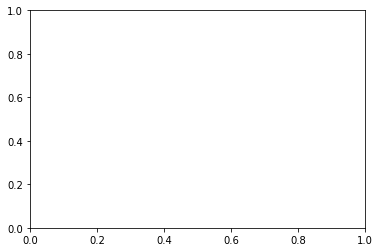

In [7]:
def plot_aop_refl(band_array,refl_extent,colorlimit=(0,1),ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='Greys'):
    
    '''plot_refl_data reads in and plots a single band or 3 stacked bands of a reflectance array
    --------
    Parameters
    --------
        band_array: array of reflectance values, created from aop_h5refl2array
        refl_extent: extent of reflectance data to be plotted (xMin, xMax, yMin, yMax) 
                     use metadata['spatial extent'] from aop_h5refl2array function
        colorlimit: optional, range of values to plot (min,max). 
                    - helpful to look at the histogram of reflectance values before plotting to determine colorlimit.
        ax: optional, default = current axis
        title: optional; plot title (string)
        cmap_title: optional; colorbar title 
        colormap: optional (string, see https://matplotlib.org/examples/color/colormaps_reference.html) for list of colormaps
    --------
    Returns 
    --------
        plots flightline array of single band of reflectance data
    --------

    Examples:
    --------
    plot_aop_refl(sercb56,
              sercMetadata['spatial extent'],
              colorlimit=(0,0.3),
              title='SERC Band 56 Reflectance',
              cmap_title='Reflectance',
              colormap='Greys_r') '''
    
    import matplotlib.pyplot as plt
    
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation for ticklabels
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

Now that we have loaded this function, let's extract a single band from the SERC reflectance array and plot it:

In [8]:
sercb56 = sercRefl[:,:,55]

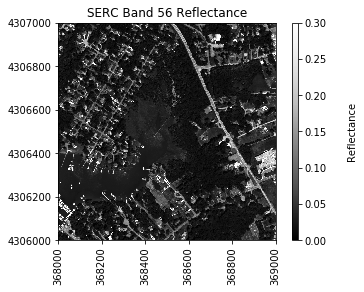

In [9]:
plot_aop_refl(sercb56,
              sercMetadata['spatial extent'],
              colorlimit=(0,0.3),
              title='SERC Band 56 Reflectance',
              cmap_title='Reflectance',
              colormap='Greys_r') 

## RGB Plots - Band Stacking
It is often useful to look at several bands together. We can extract and stack three reflectance bands in the red, green, and blue (RGB) spectrums to produce a color image that looks like what we see with our eyes; this is your typical camera image. In the next part of this tutorial, we will learn to stack multiple bands and make a geotif raster from the compilation of these bands. We can see that different combinations of bands allow for different visualizations of the remotely-sensed objects and also conveys useful information about the chemical makeup of the Earth's surface. 

We will select bands that fall within the visible range of the electromagnetic 
spectrum (400-700 nm) and at specific points that correspond to what we see 
as red, green, and blue.

<figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral/spectrum_RGBcombined.jpg">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral/spectrum_RGBcombined.jpg"></a>
	<figcaption> NEON Imaging Spectrometer bands and their respective nanometers. Source: National Ecological Observatory Network (NEON)  
	</figcaption>
</figure>

For this exercise, we'll first use the neon_aop_module function `stack_rgb` to extract the bands we want to stack. This function uses splicing to extract the nth band from the reflectance array, and then uses the numpy function `stack` to create a new 3D array (1000 x 1000 x 3) consisting of only the three bands we want. 

In [10]:
def stack_rgb(reflArray,bands):
    
    import numpy as np
    
    red = reflArray[:,:,bands[0]-1]
    green = reflArray[:,:,bands[1]-1]
    blue = reflArray[:,:,bands[2]-1]
    
    stackedRGB = np.stack((red,green,blue),axis=2)
    
    return stackedRGB

First, we will look at red, green, and blue bands, whos indices are defined below. To confirm that these band indices correspond to wavelengths in the expected portion of the spectrum, we can print out the wavelength values stored in `metadata['wavelength']`:

In [11]:
rgb_bands = (58,34,19)

print('Band 58 Center Wavelength = %.2f' %(sercMetadata['wavelength'][57]),'nm')
print('Band 33 Center Wavelength = %.2f' %(sercMetadata['wavelength'][33]),'nm')
print('Band 19 Center Wavelength = %.2f' %(sercMetadata['wavelength'][18]),'nm')

Band 58 Center Wavelength = 668.98 nm
Band 33 Center Wavelength = 548.80 nm
Band 19 Center Wavelength = 473.68 nm


Below we use `stack_rgb` to create an RGB array. Check that the dimensions of this array are as expected.

**Data Tip**: Checking the shape of arrays with `.shape` is a good habit to get into when creating your own workflows, and can be a handy tool for troubleshooting. 

In [12]:
SERCrgb = stack_rgb(sercRefl,rgb_bands)
SERCrgb.shape

(1000, 1000, 3)

## plot_aop_refl: plot an RGB band combination

Next, we can use the function `plot_aop_refl`, even though we have more than one band. This function only works for a single or 3-band array, so ensure the array you use has the proper dimensions before using. You do not need to specify the colorlimits as the `matplotlib.pyplot` automatically scales 3-band arrays to 8-bit color (256). 

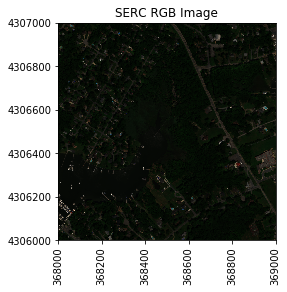

In [13]:
plot_aop_refl(SERCrgb,
               sercMetadata['spatial extent'],
               title='SERC RGB Image',
               cbar='off') 

You'll notice that this image is very dark; it is possible to make out some of the features (roads, buildings), but it is not ideal. Since colorlimits don't apply to 3-band images, we have to use some other image processing tools to enhance the visibility of this image. 

## Image Processing -- Contrast Stretch & Histogram Equalization 

We can also try out some image processing routines to better visualize the reflectance data using the ```ski-image``` package. 

Histogram equalization is a method in image processing of contrast adjustment using the image's histogram. Stretching the histogram can improve the contrast of a displayed image by eliminating very high or low reflectance values that skew the display of the image. 

 <figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/histogram_equalization.png">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/histogram_equalization.png"></a>
	<figcaption> Histogram equalization is a method in image processing of contrast adjustment 
using the image's histogram. Stretching the histogram can improve the contrast 
of a displayed image, as we will show how to do below.
	Source: <a href="https://en.wikipedia.org/wiki/Talk%3AHistogram_equalization#/media/File:Histogrammspreizung.png"> Wikipedia - Public Domain </a>
	</figcaption>
</figure>

*The following tutorial section is adapted from skikit-image's tutorial
<a href="http://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py" target="_blank"> Histogram Equalization</a>.*

Let's see what the image looks like using a 5% linear contrast stretch using the `skiimage` module's `exposure` function.

In [14]:
from skimage import exposure

In [15]:
def plot_aop_rgb(rgbArray,ext,ls_pct=5,plot_title=''):
    
    from skimage import exposure
    
    pLow, pHigh = np.percentile(rgbArray[~np.isnan(rgbArray)], (ls_pct,100-ls_pct))
    img_rescale = exposure.rescale_intensity(rgbArray, in_range=(pLow,pHigh))
    plt.imshow(img_rescale,extent=ext)
    plt.title(plot_title + '\n Linear ' + str(ls_pct) + '% Contrast Stretch'); 
    ax = plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

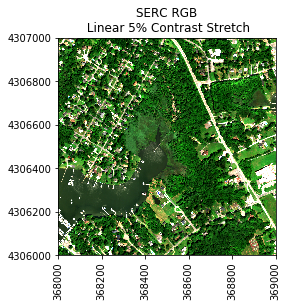

In [16]:
plot_aop_rgb(SERCrgb,
             sercMetadata['spatial extent'],
             plot_title = 'SERC RGB')

## False Color Image - Color Infrared (CIR)
We can also create an image from bands outside of the visible spectrum. An image containing one or more bands outside of the visible range is called a **false-color image**. Here we'll use the green and blue bands as before, but we replace the red band with a near-infrared (NIR) band. 

For more information about non-visible wavelengths, false color images, and some frequently used false-color band combinations, refer to <a href="https://earthobservatory.nasa.gov/Features/FalseColor/" target="_blank">NASA's Earth Observatory page</a>.


Band 90 Center Wavelength = 829.24 nm
Band 34 Center Wavelength = 548.80 nm
Band 19 Center Wavelength = 473.68 nm


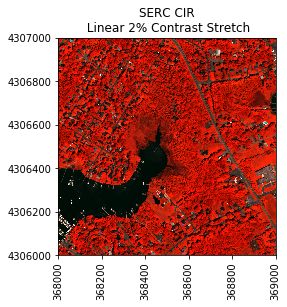

In [17]:
CIRbands = (90,34,19)
print('Band 90 Center Wavelength = %.2f' %(sercMetadata['wavelength'][89]),'nm')
print('Band 34 Center Wavelength = %.2f' %(sercMetadata['wavelength'][33]),'nm')
print('Band 19 Center Wavelength = %.2f' %(sercMetadata['wavelength'][18]),'nm')

SERCcir = stack_rgb(sercRefl,CIRbands)
plot_aop_rgb(SERCcir,
             sercMetadata['spatial extent'],
             ls_pct=2,
             plot_title='SERC CIR')

## Demo: Exploring Band Combinations Interactively

Now that we have made a couple different band combinations, we can demo a Python `widget` to explore different combinations of bands in the visible and non-visible portions of the spectrum. 

In [18]:
from IPython.html.widgets import *

In [19]:
array = copy.copy(sercRefl)
metadata = copy.copy(sercMetadata)

def RGBplot_widget(R,G,B):
    
    #Pre-allocate array  size
    rgbArray = np.zeros((array.shape[0],array.shape[1],3), 'uint8')
    
    Rband = array[:,:,R-1].astype(np.float)
    #Rband_clean = clean_band(Rband,Refl_md)
    
    Gband = array[:,:,G-1].astype(np.float)
    #Gband_clean = clean_band(Gband,Refl_md)
    
    Bband = array[:,:,B-1].astype(np.float)
    #Bband_clean = clean_band(Bband,Refl_md)
    
    rgbArray[..., 0] = Rband*256
    rgbArray[..., 1] = Gband*256
    rgbArray[..., 2] = Bband*256
    
    # Apply Adaptive Histogram Equalization to Improve Contrast:
    
    img_nonan = np.ma.masked_invalid(rgbArray) #first mask the image 
    img_adapteq = exposure.equalize_adapthist(img_nonan, clip_limit=0.10)
    
    plot = plt.imshow(img_adapteq,extent=metadata['spatial extent']); 
    plt.title('Bands: \nR:' + str(R) + ' (' + str(round(metadata['wavelength'][R-1])) +'nm)'
              + '\n G:' + str(G) + ' (' + str(round(metadata['wavelength'][G-1])) + 'nm)'
              + '\n B:' + str(B) + ' (' + str(round(metadata['wavelength'][B-1])) + 'nm)'); 
    ax = plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) 
    
interact(RGBplot_widget, R=(1,426,1), G=(1,426,1), B=(1,426,1))

interactive(children=(IntSlider(value=213, description='R', max=426, min=1), IntSlider(value=213, description='G', max=426, min=1), IntSlider(value=213, description='B', max=426, min=1), Output()), _dom_classes=('widget-interact',))

<function __main__.RGBplot_widget>

## Demo: Interactive Linear Stretch & Equalization

Here is another widget to play around with, demonstrating how to interactively visualize linear contrast stretches with a variable percent. 

In [20]:
rgbArray = copy.copy(SERCrgb)

def linearStretch(percent):
    pLow, pHigh = np.percentile(rgbArray[~np.isnan(rgbArray)], (percent,100-percent))
    img_rescale = exposure.rescale_intensity(rgbArray, in_range=(pLow,pHigh))
    plt.imshow(img_rescale,extent=sercMetadata['spatial extent'])
    plt.title('SERC RGB \n Linear ' + str(percent) + '% Contrast Stretch'); 
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) 

interact(linearStretch,percent=(0,20,1))

interactive(children=(IntSlider(value=10, description='percent', max=20), Output()), _dom_classes=('widget-interact',))

<function __main__.linearStretch>

## References

Kekesi, Alex et al. 
<a href="https://svs.gsfc.nasa.gov/vis/a010000/a011400/a011491/" target="_blank"> "NASA | Peeling Back Landsat's Layers of Data". </a>
https://svs.gsfc.nasa.gov/vis/a010000/a011400/a011491/. Published on Feb 24, 2014.

Riebeek, Holli. 
<a href="https://earthobservatory.nasa.gov/Features/FalseColor/" target="_blank"> "Why is that Forest Red and that Cloud Blue? How to Interpret a False-Color Satellite Image" </a> 
https://earthobservatory.nasa.gov/Features/FalseColor/ 
